In [212]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

In [213]:
pop_url = "https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=county:*&in=state:34&key=52e4b71218eb4d492e49c7dcde830174d23a8db9"
age_sex_url = "https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP,SEX,AGEGROUP&for=county:*&in=state:34&key=52e4b71218eb4d492e49c7dcde830174d23a8db9"

In [214]:
pop_response = requests.get(pop_url)
age_sex_response = requests.get(age_sex_url)
print(pop_response.url)
print(age_sex_response.url)

https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=county:*&in=state:34&key=52e4b71218eb4d492e49c7dcde830174d23a8db9
https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP,SEX,AGEGROUP&for=county:*&in=state:34&key=52e4b71218eb4d492e49c7dcde830174d23a8db9


# Data Cleaning

In [215]:
#Base Population DataFrame from Census API
pop_data = pop_response.json()
#print(json.dumps(pop_data, indent=4, sort_keys=True))
pop_df = pd.DataFrame((pop_data), columns=("County","Population","State_Num","County_Num"))
pop_df = pop_df.drop(0).reset_index(drop=True)
pop_df["County"] = pop_df["County"].str.split(',',expand=True)
pop_df["County_Num"] = pop_df["State_Num"] + pop_df["County_Num"]
pop_df = pop_df.sort_values(["County"], ascending=True)

In [216]:
pop_df["Population"] = pop_df["Population"].astype(float)
tot_pop = pop_df["Population"].sum()
tot_pop

8882190.0

## Age and Gender Population data Cleaning

#### Gender Population DataFrame

In [217]:
age_sex_data = age_sex_response.json()
#print(json.dumps(age_sex_data, indent=4, sort_keys=True))

In [218]:
age_sex_df = pd.DataFrame((age_sex_data), columns=("County","Population", "Gender","Age_group", "State_Num","County_Num"))
age_sex_df = age_sex_df.drop(0).reset_index(drop=True)
age_sex_df["County"] = age_sex_df["County"].str.split(',',expand=True)
age_sex_df["County_Num"] = age_sex_df["State_Num"] + age_sex_df["County_Num"]
age_sex_df["Gender"] = age_sex_df["Gender"].replace(["0","1","2"],['M&F', "Male", "Female"])
age_sex_df["Age_group"] = age_sex_df["Age_group"].replace(["0","1","2","3", "4", "5","6","7","8","9","10","11","12","13","14","15","16",
"17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"],["All ages",
"0 to 4 years",
"5 to 9 years",
"10 to 14 years",
"15 to 19 years",
"20 to 24 years",
"25 to 29 years",
"30 to 34 years",
"35 to 39 years",
"40 to 44 years",
"45 to 49 years",
"50 to 54 years",
"55 to 59 years",
"60 to 64 years",
"65 to 69 years",
"70 to 74 years",
"75 to 79 years",
"80 to 84 years",
"85 years and older",
"Under 18 years",  
"5 to 13 years",  
"14 to 17 years",  
"18 to 64 years", 
"18 to 24 years",  
"25 to 44 years",  
"45 to 64 years",  
"65 years and over",  
"85 years and over",  
"16 years and over",  
"18 years and over", 
"15 to 44 years",  
"Median age"])
age_sex_df["Population"] = age_sex_df["Population"].astype(float)

In [219]:
### Population by Gender
sex_array = ["All ages"]
m_f_array = ["Male", "Female"]
reduced_sex_df = age_sex_df.loc[age_sex_df["Age_group"].isin(sex_array)]
reduced_sex_df = reduced_sex_df.loc[age_sex_df["Gender"].isin(m_f_array)]
reduced_sex_df = reduced_sex_df.reset_index(drop=True)
reduced_sex_df = reduced_sex_df.drop(["Age_group"],axis = 1)

In [220]:
#Groupby County, Gender
group_sex = reduced_sex_df.groupby(["County", "Gender"])
group_sex_df = pd.DataFrame(group_sex["Population"].sum())

In [221]:
#slice for male and female
idx = pd.IndexSlice

Female_df = group_sex_df.loc[idx[:,["Female"]], :]
Male_df = group_sex_df.loc[idx[:,["Male"]], :]

In [222]:
#Merge Gender Population to Total Population DataFrame
sex_merged_df = pd.merge(pop_df, Female_df, on="County")
both_sex_merged_df = pd.merge(sex_merged_df, Male_df, on="County")
both_sex_merged_df = both_sex_merged_df.rename(columns={"Population_x":"Total_Population","Population_y":"Female_Pop","Population": "Male_pop"})
both_sex_merged_df

,County,Total_Population,State_Num,County_Num,Female_Pop,Male_pop
0,Atlantic County,263670.0,34,34001,136079.0,127591.0
1,Bergen County,932202.0,34,34003,479536.0,452666.0
2,Burlington County,445349.0,34,34005,226147.0,219202.0
3,Camden County,506471.0,34,34007,262041.0,244430.0
4,Cape May County,92039.0,34,34009,47171.0,44868.0
5,Cumberland County,149527.0,34,34011,73366.0,76161.0
6,Essex County,798975.0,34,34013,414401.0,384574.0
7,Gloucester County,291636.0,34,34015,149790.0,141846.0
8,Hudson County,672391.0,34,34017,337404.0,334987.0
9,Hunterdon County,124371.0,34,34019,63032.0,61339.0


### Age population dataframe

In [223]:
### Total Population by Age groups
Age_array = ["50 to 54 years",
"55 to 59 years",
"60 to 64 years","Under 18 years","18 to 24 years",  
"25 to 44 years","45 to 49 years","65 years and over"]
both_genders_array = ["M&F"]
reduced_age_df = age_sex_df.loc[age_sex_df["Gender"].isin(both_genders_array)]
reduced_age_df = reduced_age_df.loc[age_sex_df["Age_group"].isin(Age_array)]
reduced_age_df = reduced_age_df.reset_index(drop=True)
reduced_age_df = reduced_age_df.drop(["Gender"],axis = 1)

In [224]:
#### Group by County, Age
group_age_df = reduced_age_df.groupby(["County", "Age_group"]).sum()

In [225]:
## Slice data for each age group
idx = pd.IndexSlice

under_eighteen_df = group_age_df.loc[idx[:,["Under 18 years"]], :]
over_sixtyfive_df = group_age_df.loc[idx[:,["65 years and over"]], :]

eighteen_to_twentyfour_df = group_age_df.loc[idx[:,["18 to 24 years"]], :]
twentyfive_to_fourtyfour_df = group_age_df.loc[idx[:,["25 to 44 years"]], :]
fourtyfour_to_fourtynine_df = group_age_df.loc[idx[:,["45 to 49 years"]], :]

fifty_to_fiftyfour_df = group_age_df.loc[idx[:,["50 to 54 years"]], :]
fiftyfive_to_fiftynine_df = group_age_df.loc[idx[:,["55 to 59 years"]], :]
sixty_to_sixtyfour_df = group_age_df.loc[idx[:,["60 to 64 years"]], :]

In [226]:
## 18 - 49 dataframe
eighteen_to_twentyfour_merged_df = pd.merge(eighteen_to_twentyfour_df,twentyfive_to_fourtyfour_df, on="County",how="left")
eighteen_to_fourtynine_base_merged_df = pd.merge(eighteen_to_twentyfour_merged_df, fourtyfour_to_fourtynine_df, on="County",how="left")

cols_to_sum = eighteen_to_fourtynine_base_merged_df.columns[ : eighteen_to_fourtynine_base_merged_df.shape[1]]
eighteen_to_fourtynine_base_merged_df['18_to_49_years_population'] = eighteen_to_fourtynine_base_merged_df[cols_to_sum].sum(axis=1)
eighteen_to_fourtynine_merged_df = eighteen_to_fourtynine_base_merged_df.drop(["Population","Population_x","Population_y"],axis=1)

In [227]:
## 50 - 64 dataframe
fifty_to_fiftyfour_merged_df = pd.merge(fifty_to_fiftyfour_df,fiftyfive_to_fiftynine_df, on="County",how="left")
fifty_to_sixtyfour_base_merged_df = pd.merge(fifty_to_fiftyfour_merged_df, sixty_to_sixtyfour_df, on="County",how="left")

other_cols_to_sum = fifty_to_sixtyfour_base_merged_df.columns[ : fifty_to_sixtyfour_base_merged_df.shape[1]]
fifty_to_sixtyfour_base_merged_df['50_to_64_years_population'] = fifty_to_sixtyfour_base_merged_df[cols_to_sum].sum(axis=1)
fifty_to_sixtyfour_base_merged_df = fifty_to_sixtyfour_base_merged_df.drop(["Population","Population_x","Population_y"],axis=1)

### Finale age/gender population dataframe

In [228]:
## Merged Age and Gender Population DataFrame

under_eighteen_merged_df = pd.merge(both_sex_merged_df, under_eighteen_df, on="County",how='left')
eighteen_to_fourtynine_base_merged_df = pd.merge(under_eighteen_merged_df, eighteen_to_fourtynine_merged_df, on="County",how='left')
fifty_to_sixtyfour_merged_df = pd.merge(eighteen_to_fourtynine_base_merged_df, fifty_to_sixtyfour_base_merged_df, on="County",how="left")
over_sixtyfive_merged_df = pd.merge(fifty_to_sixtyfour_merged_df, over_sixtyfive_df, on="County",how="left")

over_sixtyfive_merged_df = over_sixtyfive_merged_df.rename(columns={"Population_x": "Under_18_Population","Population_y": "65_and_over_Population"})
tot_age_gender_pop_df = over_sixtyfive_merged_df[["County","County_Num","State_Num","Female_Pop","Male_pop","Total_Population","Under_18_Population","18_to_49_years_population","50_to_64_years_population","65_and_over_Population"]]
tot_age_gender_pop_df["County"] = tot_age_gender_pop_df["County"].str.upper()

# Gender/Age Cases Cleaning

In [229]:
Total_case_url = "https://data.cdc.gov/resource/n8mc-b4w4.json?res_state=NJ&$limit=1100000"

In [230]:
tot_case_G_A_response = requests.get(Total_case_url)
print(tot_case_G_A_response.url)

https://data.cdc.gov/resource/n8mc-b4w4.json?res_state=NJ&$limit=1100000


In [231]:
gender_age_cases_raw = tot_case_G_A_response.json()
gender_age_cases_df = pd.DataFrame(gender_age_cases_raw)
gender_age_cases_df = gender_age_cases_df[["state_fips_code","res_county","county_fips_code","age_group","sex"]]
gender_age_cases_df = gender_age_cases_df.rename(columns={"res_county":"County"})
gender_age_cases_df['County'] = gender_age_cases_df['County'].astype(str) + ' COUNTY'

### Total cases per Gender

In [232]:
cases_gender_df = gender_age_cases_df.groupby(["County", "sex"]).count()
cases_gender_df = cases_gender_df.rename(columns={"state_fips_code":"cases_per_gender"})
cases_gender_df = cases_gender_df[["cases_per_gender"]]

In [233]:
Female_cases_df = cases_gender_df.loc[idx[:,["Female"]], :]
Male_cases_df = cases_gender_df.loc[idx[:,["Male"]], :]

### Total cases by Age-group

In [234]:
cases_age_df = gender_age_cases_df.groupby(["County", "age_group"]).count()
cases_age_df = cases_age_df.rename(columns={"county_fips_code":"cases_per_age"})
cases_age_df = cases_age_df[["cases_per_age"]]

In [235]:
under18_cases_df = cases_age_df.loc[idx[:,["0 - 17 years"]], :]
eighteen_to_fourtynine_cases_df = cases_age_df.loc[idx[:,["18 to 49 years"]], :]
fifty_to_sixtyfour_cases_df = cases_age_df.loc[idx[:,["50 to 64 years"]], :]
over65_cases_df = cases_age_df.loc[idx[:,["65+ years"]], :]

In [236]:
## age group cases dataframe 
first_age_merge = pd.merge(under18_cases_df,eighteen_to_fourtynine_cases_df, on="County", how="left")
second_age_merge = pd.merge(first_age_merge,fifty_to_sixtyfour_cases_df, on="County", how="left")
final_age_merge = pd.merge(second_age_merge,over65_cases_df, on="County", how="left")
final_age_merge.columns=["under18_cases","18_to_49_cases","50_to_64_cases","65+_cases"]
final_age_merge["Total_cases_by_age"] = final_age_merge["under18_cases"]+final_age_merge["18_to_49_cases"]+final_age_merge["50_to_64_cases"]+final_age_merge["65+_cases"]

# Final Clean-Merged DataFrame

In [237]:
female_cases_merged_df = pd.merge(tot_age_gender_pop_df, Female_cases_df, on="County",how='left')
Gender_cases_pop_df = pd.merge(female_cases_merged_df, Male_cases_df, on="County",how='left')
Gender_cases_pop_df = Gender_cases_pop_df.rename(columns={"cases_per_gender_x": "Female_cases", "cases_per_gender_y": "Male_cases"})
Gender_cases_pop_df["Total__gender_cases_w/o_unknown"] = Gender_cases_pop_df["Female_cases"] + Gender_cases_pop_df["Male_cases"] 
Gender_age_cases_pop_df = pd.merge(Gender_cases_pop_df, Male_cases_df, on="County",how='left')
Total_gender_age_cases_pop = pd.merge(Gender_age_cases_pop_df, final_age_merge, on="County",how='left')
Total_gender_age_cases_pop = Total_gender_age_cases_pop.drop(["State_Num","cases_per_gender"],axis=1)
Total_gender_age_cases_pop = Total_gender_age_cases_pop.set_index("County")


Total_gender_age_cases_pop.to_csv("Age_Gender_cases_population.csv")
Total_gender_age_cases_pop


,County_Num,Female_Pop,Male_pop,Total_Population,Under_18_Population,18_to_49_years_population,50_to_64_years_population,65_and_over_Population,Female_cases,Male_cases,Total__gender_cases_w/o_unknown,under18_cases,18_to_49_cases,50_to_64_cases,65+_cases,Total_cases_by_age
County,,,,,,,,,,,,,,,,
ATLANTIC COUNTY,34001,136079.0,127591.0,263670.0,55537.0,101017.0,58089.0,49027.0,17255,15353,32608,4035,16432,7268,4676,32411
BERGEN COUNTY,34003,479536.0,452666.0,932202.0,196309.0,370475.0,200750.0,164668.0,54201,51968,106169,14645,51608,23955,15593,105801
BURLINGTON COUNTY,34005,226147.0,219202.0,445349.0,92159.0,177598.0,98227.0,77365.0,22639,22150,44789,5367,23317,10013,5833,44530
CAMDEN COUNTY,34007,262041.0,244430.0,506471.0,114223.0,209032.0,101686.0,81530.0,30803,27025,57828,7226,30336,12033,7740,57335
CAPE MAY COUNTY,34009,47171.0,44868.0,92039.0,15950.0,29627.0,21296.0,25166.0,4774,4598,9372,1103,4530,2206,1807,9646
CUMBERLAND COUNTY,34011,73366.0,76161.0,149527.0,35480.0,62520.0,28135.0,23392.0,9137,8976,18113,1863,9926,3779,2451,18019
ESSEX COUNTY,34013,414401.0,384574.0,798975.0,189397.0,346184.0,152292.0,111102.0,50547,45174,95721,12657,50349,20423,12237,95666
GLOUCESTER COUNTY,34015,149790.0,141846.0,291636.0,63099.0,117965.0,63000.0,47572.0,16416,14660,31076,3974,16371,6691,4067,31103
HUDSON COUNTY,34017,337404.0,334987.0,672391.0,136715.0,342843.0,110926.0,81907.0,44734,43143,87877,9333,49901,17990,10720,87944


# Visualizations/Analysis

### Gender Analysis

<AxesSubplot:title={'center':'Total Gender Population and Cases'}, xlabel='County', ylabel='Population and Cases'>

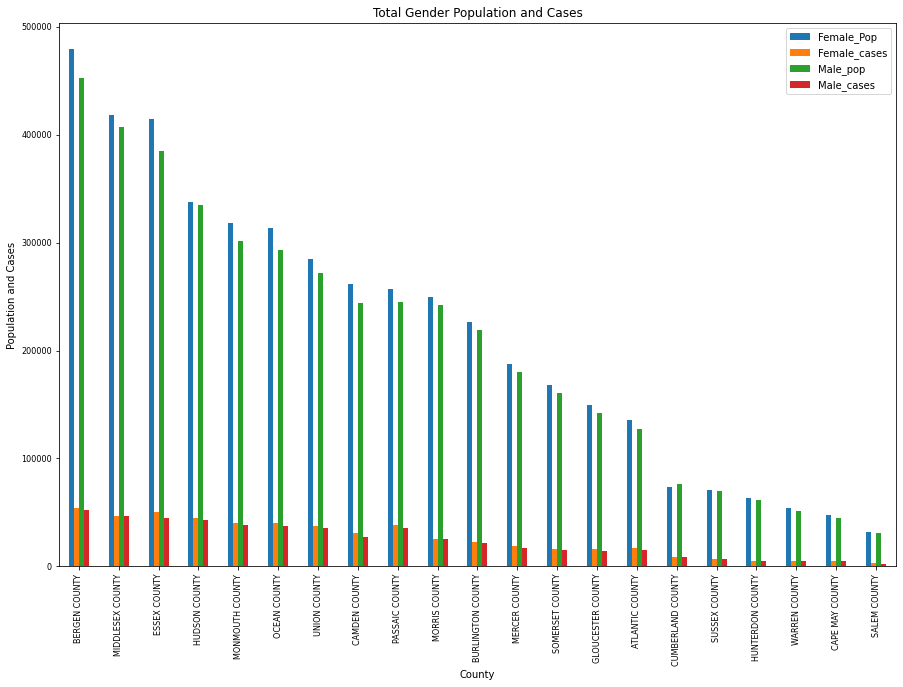

In [238]:
Total_gender_cases_by_pop = Total_gender_age_cases_pop[["Female_Pop","Female_cases","Male_pop","Male_cases"]]
gender_bar_chart = Total_gender_cases_by_pop.sort_values('Female_Pop',ascending=False).plot(kind='bar', title ="Total Gender Population and Cases", figsize=(15, 10), legend=True, fontsize=8)
plt.ylabel("Population and Cases")


plt.savefig("../Images/gender_cases_to_population.png")
gender_bar_chart


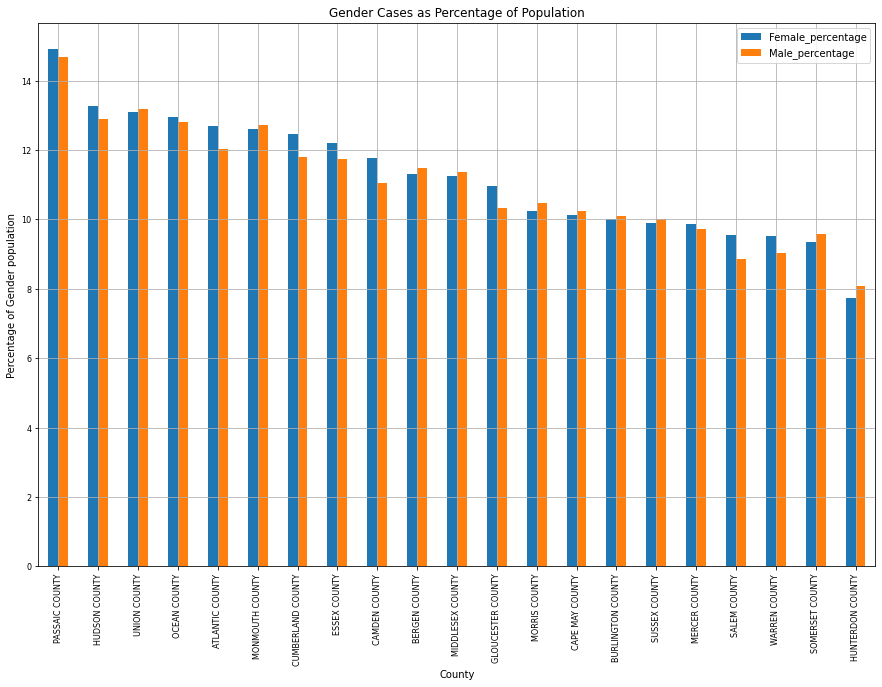

In [239]:
### Percentage of gender cases to gender population
percent_gender_cases = pd.DataFrame(Total_gender_cases_by_pop)
percent_gender_cases["Female_percentage"] = (percent_gender_cases["Female_cases"]/percent_gender_cases["Female_Pop"]*100).map("{:,.2f}".format).astype(float)
percent_gender_cases["Male_percentage"] = (percent_gender_cases["Male_cases"]/percent_gender_cases["Male_pop"]*100).map("{:,.2f}".format).astype(float)

percent_gender_cases_of_pop = percent_gender_cases[["Female_percentage","Male_percentage"]]
percent_gender_cases_of_pop.sort_values("Female_percentage", ascending=False).plot(kind='bar', title ="Gender Cases as Percentage of Population", figsize=(15, 10), legend=True, fontsize=8, grid=True)
plt.ylabel("Percentage of Gender population")

plt.savefig("../Images/gender_cases_percentage.png")

plt.show()

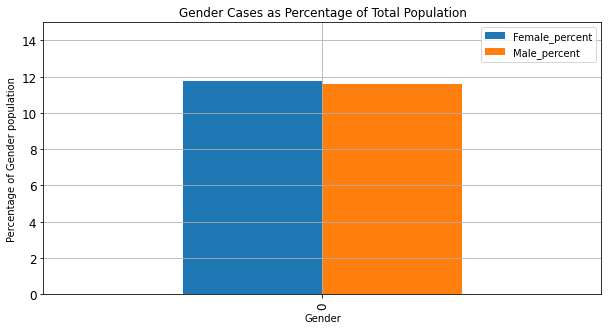

In [240]:
# NJ total gender cases to population
summed = percent_gender_cases[["Female_Pop","Female_cases","Male_pop","Male_cases"]].sum()
summed_df = pd.DataFrame(summed).T
summed_df["Female_percent"] = summed_df["Female_cases"]/summed_df["Female_Pop"]*100
summed_df["Male_percent"] = summed_df["Male_cases"]/summed_df["Male_pop"]*100
summed_df[["Female_percent","Male_percent"]].plot(kind="bar", title ="Gender Cases as Percentage of Total Population", figsize=(10, 5), legend=True, fontsize=12, grid=True)
plt.ylim(0,15)
plt.xlabel("Gender")
plt.ylabel("Percentage of Gender population")

plt.savefig("../Images/NJ_total_gender_case_percentage.png")


#### Gender Linear Regression

The r-squared is: 0.9654914134248967
The correlation between Female Population and # of Female Cases is 0.98


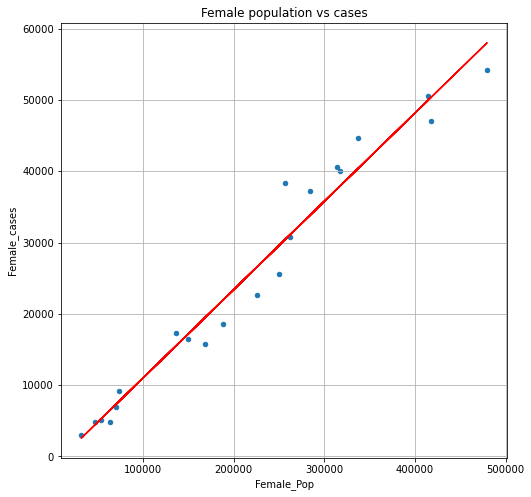

In [241]:
## Female
Total_gender_cases_by_pop.plot(kind="scatter", x="Female_Pop", y="Female_cases", grid=True, figsize=(8,8),
              title="Female population vs cases")

correlation = st.pearsonr(Total_gender_cases_by_pop["Female_Pop"],Total_gender_cases_by_pop["Female_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_gender_cases_by_pop["Female_Pop"],Total_gender_cases_by_pop["Female_cases"])
regress_values = Total_gender_cases_by_pop["Female_Pop"] * slope + intercept
plt.plot(Total_gender_cases_by_pop["Female_Pop"],regress_values,"r-")
correlation = st.pearsonr(Total_gender_cases_by_pop["Female_Pop"],Total_gender_cases_by_pop["Female_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between Female Population and # of Female Cases is {round(correlation[0],2)}")

plt.savefig("../Images/Female_cases_to_Female_population.png")

plt.show()

The r-squared is: 0.970087781688549
The correlation between Male Population and # of Male Cases is 0.98


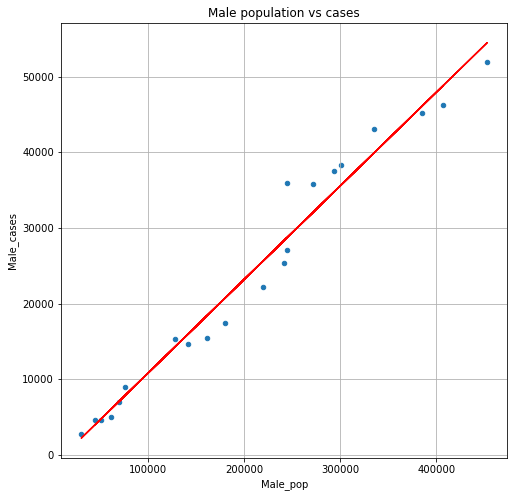

In [242]:
## Male
Total_gender_cases_by_pop.plot(kind="scatter", x="Male_pop", y="Male_cases", grid=True, figsize=(8,8),
              title="Male population vs cases")

correlation = st.pearsonr(Total_gender_cases_by_pop["Male_pop"],Total_gender_cases_by_pop["Male_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_gender_cases_by_pop["Male_pop"],Total_gender_cases_by_pop["Male_cases"])
regress_values = Total_gender_cases_by_pop["Male_pop"] * slope + intercept
plt.plot(Total_gender_cases_by_pop["Male_pop"],regress_values,"r-")
correlation = st.pearsonr(Total_gender_cases_by_pop["Male_pop"],Total_gender_cases_by_pop["Male_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between Male Population and # of Male Cases is {round(correlation[0],2)}")

plt.savefig("../Images/Male_cases_to_Male_population.png")

plt.show()

### Age group Analysis

<AxesSubplot:title={'center':'Total Age-group Cases'}, xlabel='County', ylabel='Cases'>

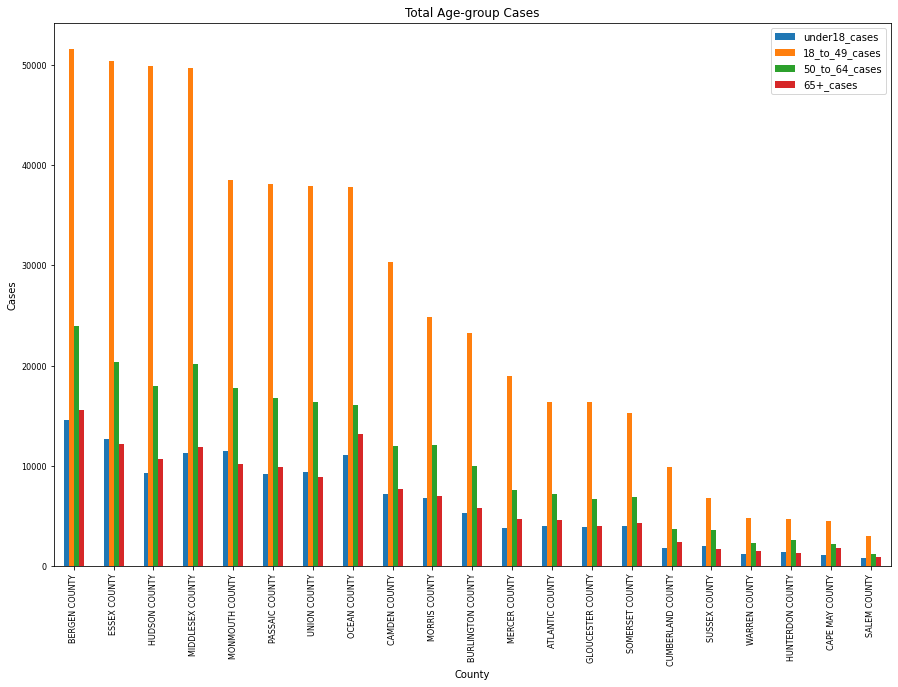

In [243]:
Total_age_cases = Total_gender_age_cases_pop[["under18_cases","18_to_49_cases","50_to_64_cases","65+_cases"]]
Age_bar_chart = Total_age_cases.sort_values("18_to_49_cases", ascending=False).plot(kind='bar', title ="Total Age-group Cases", figsize=(15, 10), legend=True, fontsize=8)

plt.savefig("../Images/age-groups_cases_to_age-groups_population.png")
plt.ylabel("Cases")

Age_bar_chart

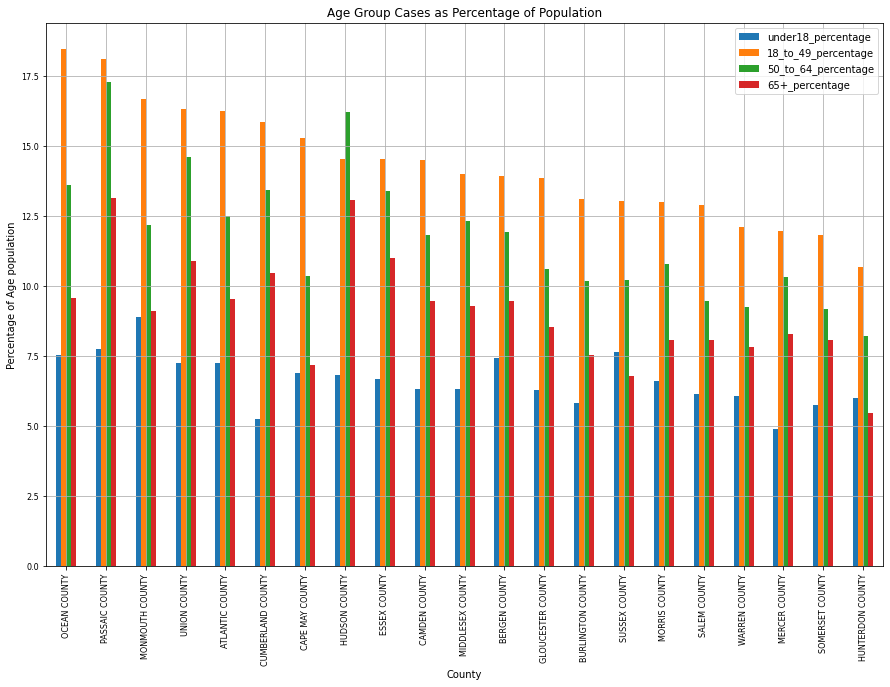

In [244]:
### Percentage of age-group cases to age-group population
Total_age_cases_by_pop = Total_gender_age_cases_pop[["Under_18_Population","under18_cases","18_to_49_years_population","18_to_49_cases","50_to_64_years_population","50_to_64_cases","65_and_over_Population","65+_cases"]]
percent_age_cases = pd.DataFrame(Total_age_cases_by_pop)
percent_age_cases["under18_percentage"] = (percent_age_cases["under18_cases"]/percent_age_cases["Under_18_Population"]*100).map("{:,.2f}".format).astype(float)
percent_age_cases["18_to_49_percentage"] = (percent_age_cases["18_to_49_cases"]/percent_age_cases["18_to_49_years_population"]*100).map("{:,.2f}".format).astype(float)
percent_age_cases["50_to_64_percentage"] = (percent_age_cases["50_to_64_cases"]/percent_age_cases["50_to_64_years_population"]*100).map("{:,.2f}".format).astype(float)
percent_age_cases["65+_percentage"] = (percent_age_cases["65+_cases"]/percent_age_cases["65_and_over_Population"]*100).map("{:,.2f}".format).astype(float)

percent_age_cases_of_pop = percent_age_cases[["under18_percentage","18_to_49_percentage","50_to_64_percentage","65+_percentage"]]
percent_age_cases_of_pop.sort_values("18_to_49_percentage", ascending=False).plot(kind='bar', title ="Age Group Cases as Percentage of Population", figsize=(15, 10), legend=True, fontsize=8, grid=True)
plt.ylabel("Percentage of Age population")

plt.savefig("../Images/age-groups_cases_percentage.png")

plt.show()

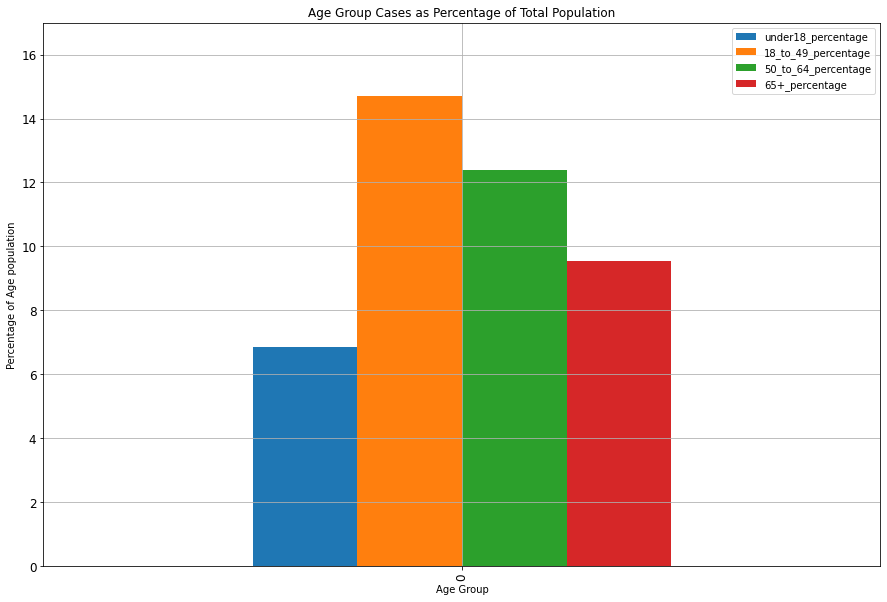

In [245]:
# NJ total age-group cases to population
summed_age = Total_gender_age_cases_pop[["Under_18_Population","under18_cases","18_to_49_years_population","18_to_49_cases","50_to_64_years_population","50_to_64_cases","65_and_over_Population","65+_cases"]].sum()
summed_age_df = pd.DataFrame(summed_age).T
summed_age_df["under18_percentage"] = summed_age_df["under18_cases"]/summed_age_df["Under_18_Population"]*100
summed_age_df["18_to_49_percentage"] = summed_age_df["18_to_49_cases"]/summed_age_df["18_to_49_years_population"]*100
summed_age_df["50_to_64_percentage"] = summed_age_df["50_to_64_cases"]/summed_age_df["50_to_64_years_population"]*100
summed_age_df["65+_percentage"] = summed_age_df["65+_cases"]/summed_age_df["65_and_over_Population"]*100

summed_age_df[["under18_percentage","18_to_49_percentage","50_to_64_percentage","65+_percentage"]].plot(kind="bar", title ="Age Group Cases as Percentage of Total Population", figsize=(15, 10), legend=True, fontsize=12, grid=True)
summed_age_df[["under18_percentage","18_to_49_percentage","50_to_64_percentage","65+_percentage"]]
plt.ylim(0, 17)
plt.xlabel("Age Group")
plt.ylabel("Percentage of Age population")

plt.savefig("../Images/NJ_total_age-group_case_percentage.png")

### Age Linear Regression

The r-squared is: 0.9593123339772164
The correlation between under 18 Population and # of under 18 Cases is 0.98


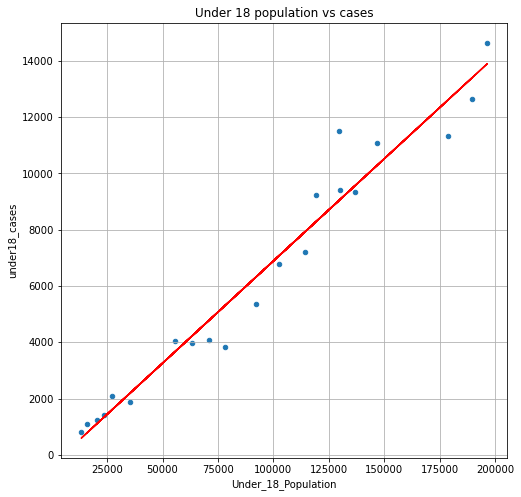

In [246]:
Total_age_cases_by_pop.plot(kind="scatter", x="Under_18_Population", y="under18_cases", grid=True, figsize=(8,8),
              title="Under 18 population vs cases")
correlation = st.pearsonr(Total_age_cases_by_pop["Under_18_Population"],Total_age_cases_by_pop["under18_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_age_cases_by_pop["Under_18_Population"],Total_age_cases_by_pop["under18_cases"])
regress_values = Total_age_cases_by_pop["Under_18_Population"] * slope + intercept
plt.plot(Total_age_cases_by_pop["Under_18_Population"],regress_values,"r-")
correlation = st.pearsonr(Total_age_cases_by_pop["Under_18_Population"],Total_age_cases_by_pop["under18_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between under 18 Population and # of under 18 Cases is {round(correlation[0],2)}")

plt.savefig("../Images/under18_cases_to_under18_population.png")

plt.show()

The r-squared is: 0.9622251337962724
The correlation between 18-49 Population and # of 18-49 Cases is 0.98


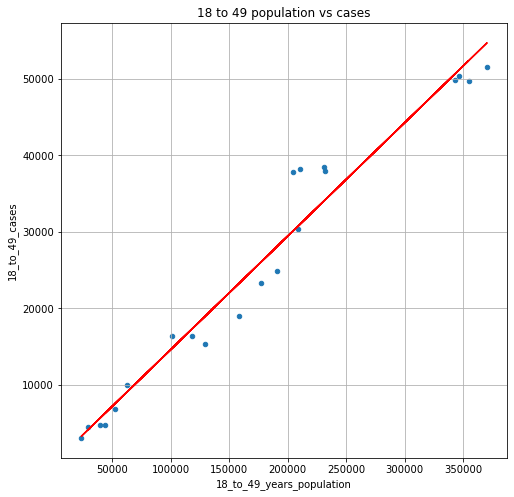

In [247]:
## 18-49
Total_age_cases_by_pop.plot(kind="scatter", x="18_to_49_years_population", y="18_to_49_cases", grid=True, figsize=(8,8),
              title="18 to 49 population vs cases")
correlation = st.pearsonr(Total_age_cases_by_pop["18_to_49_years_population"],Total_age_cases_by_pop["18_to_49_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_age_cases_by_pop["18_to_49_years_population"],Total_age_cases_by_pop["18_to_49_cases"])
regress_values = Total_age_cases_by_pop["18_to_49_years_population"] * slope + intercept
plt.plot(Total_age_cases_by_pop["18_to_49_years_population"],regress_values,"r-")
correlation = st.pearsonr(Total_age_cases_by_pop["18_to_49_years_population"],Total_age_cases_by_pop["18_to_49_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between 18-49 Population and # of 18-49 Cases is {round(correlation[0],2)}")

plt.savefig("../Images/18-49_cases_to_18-49_population.png")

plt.show()

The r-squared is: 0.9305691491581521
The correlation between 50-64 Population and # of 50-64 Cases is 0.96


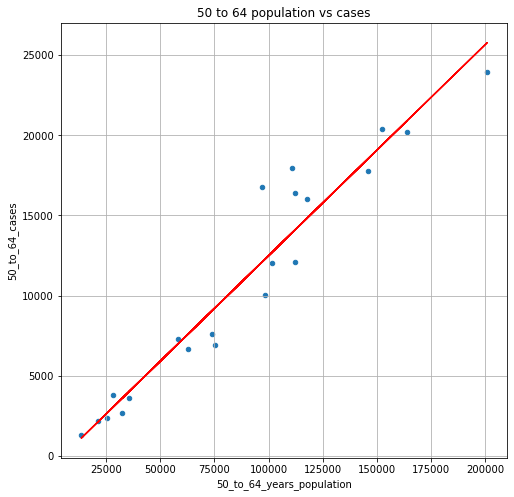

In [248]:
## 50-64
Total_age_cases_by_pop.plot(kind="scatter", x="50_to_64_years_population", y="50_to_64_cases", grid=True, figsize=(8,8),
              title="50 to 64 population vs cases")
correlation = st.pearsonr(Total_age_cases_by_pop["50_to_64_years_population"],Total_age_cases_by_pop["50_to_64_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_age_cases_by_pop["50_to_64_years_population"],Total_age_cases_by_pop["50_to_64_cases"])
regress_values = Total_age_cases_by_pop["50_to_64_years_population"] * slope + intercept
plt.plot(Total_age_cases_by_pop["50_to_64_years_population"],regress_values,"r-")
correlation = st.pearsonr(Total_age_cases_by_pop["50_to_64_years_population"],Total_age_cases_by_pop["50_to_64_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between 50-64 Population and # of 50-64 Cases is {round(correlation[0],2)}")


plt.savefig("../Images/50-64_cases_to_50-64_population.png")

plt.show()

The r-squared is: 0.934252679056429
The correlation between 65+ Population and # of 65+ Cases is 0.97


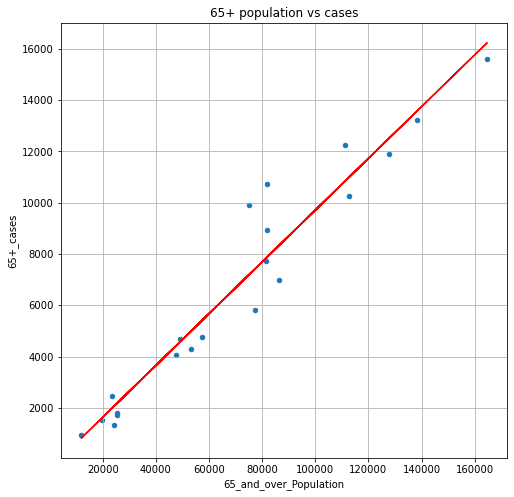

In [249]:
## 65+
Total_age_cases_by_pop.plot(kind="scatter", x="65_and_over_Population", y="65+_cases", grid=True, figsize=(8,8),
              title="65+ population vs cases")
correlation = st.pearsonr(Total_age_cases_by_pop["65_and_over_Population"],Total_age_cases_by_pop["65+_cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(Total_age_cases_by_pop["65_and_over_Population"],Total_age_cases_by_pop["65+_cases"])
regress_values = Total_age_cases_by_pop["65_and_over_Population"] * slope + intercept
plt.plot(Total_age_cases_by_pop["65_and_over_Population"],regress_values,"r-")
correlation = st.pearsonr(Total_age_cases_by_pop["65_and_over_Population"],Total_age_cases_by_pop["65+_cases"])
print(f"The r-squared is: {rvalue**2}")
print(f"The correlation between 65+ Population and # of 65+ Cases is {round(correlation[0],2)}")

plt.savefig("../Images/65+_cases_to_65+_population.png")

plt.show()